# Exploring Guilt in The Moonstone

Gene Yoo

Aug 15, 2020

Introduction to Computational Literary Analysis

University of California, Berkeley

Instructor: Jonathan Reeve

# Introduction
Wilkie Collins' *The Moonstone* <sup id="a1">[1](#f1)</sup> is a character-dense mystery novel, featuring several narrators throughout the text. While there are many characters introduced in the novel, only 7 narrate: Gabriel Betteredge, Drusilla Clack, Mr. Bruff, Franklin Blake, Ezra Jennings, Sergeant Cuff and Dr. Candy.

Because these characters narrate, we have access to both their dialogues and monologues. For the purpose of this analysis, we will be focusing on the monologues. These monologues can provide us insight to the internal thoughts and feelings for the respective narrators. With this, we have access to a sizeable sample of the thoughts of these key characters.

We use a computational approach using Sentence Comparison in order to analyze one emotion in particular -- Guilt -- as this is one of the common themes throughout uncovering the mystery of The Moonstone. We derive scores from Sentence Comparison as a proxy to Guilt, and compare the scores among each of the narrators. Finally, we use these scores to describe the behavior and thoughtprocess of the characters in the text.

In [1]:
import pprint
import json
from operator import itemgetter
import os
import re
import string

import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords

import numpy as np
import pandas as pd 

from scipy import spatial

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

import spacy
import statistics

In [2]:
pp = pprint.PrettyPrinter(indent=4, depth=20)
nlp = spacy.load('en_core_web_lg')

# Approach

In order to obtain viable candiates for Sentence Comparison, we will have to do the following steps:
1. Extract the text from *The Moonstone*
2. Separate the text into the sections corresponding to each of the narrators to get:
   ```
   {$narrator : [sentence1, ..., sentenceMax]}
   ```

3. Filter out each section for monologues (i.e. sentences without quotation marks) to get:
   ```
   {$narrator : [monologueSentence1, ..., monologueSentenceMax]}
   ```

4. Implement a strategy for Sentence Comparison

5. Compare the monologue sentences against seed sentences related to Guilt, to get:
    ```
    {$narrator : [guiltScore1, ... , guiltScoreMax]}
    ```

This leaves us with a framework to extract any emotion for the characters.

### 1 - Extracting the Text

In [3]:
moonstone = open('../Readings/content/texts/moonstone.md', encoding="utf8").read()
moonstoneParts = moonstone.split('\n## ')
keys_expanded = ['clack', 'bruff', 'blake', 'jennings', 'blake2', 'cuff', 'candy', 'betteredge2']
keys = ['betteredge', 'clack', 'bruff', 'blake', 'jennings', 'cuff', 'candy']

### 2 - Sectioning for each Narrator

In [4]:
def getNarrator(narrator):
    if 'betteredge' in narrator:
        return 'betteredge'
    elif 'blake' in narrator:
        return 'blake'
    return narrator

marker = 'Chapter I'
loc = moonstoneParts[1].find(marker)

betteredge = moonstoneParts[1][loc + len(marker):]
betteredge = re.sub(r'Chapter \w', '', betteredge)
betteredgeSents = nltk.sent_tokenize(betteredge)

def constructDict():
    narratorDict = {'betteredge' : betteredgeSents}
    fileName = "narratorDict.json"
    if os.path.exists(fileName):
        with open(fileName, "r") as read_file:
            narratorDict = json.load(read_file)
            return narratorDict

    for narrator, text in zip(keys_expanded, moonstoneParts[3:]):
        loc = text.find(marker)
        part = text[len(marker) + loc:] if loc > 0 else text
        part = re.sub(r'Chapter \w', '', part)
        sents = narratorDict.get(getNarrator(narrator), [])
        narratorDict[getNarrator(narrator)] = sents + nltk.sent_tokenize(part)
    json.dump(narratorDict, open( "narratorDict.json", 'w' ))
    return narratorDict

narratorDict = constructDict()

### 3 - Filtering for Monologue Sentences

As expected, Betteredge has the most monologue sentences, followed by Blake. This is intuitive as they have the most number of lines, and both narrate twice.
Next, is Clack, followed by the rest who have relatively smaller number of monologue lines. Not surprisingly, the number of monologue sentences is proportional to the number of lines the characters' section had. We will remember to account for this by normalizing on the number of lines.

This step is a work in progress, as it is not completely accurate. It relies on a naive assumption, which we will speak to more in the Results section. A more accurate approach would be to scan for a prior sentence with a right quote on the left side, and vice versa, but we use the naive approach for this examination.


In [5]:
def isMonologue(text):
    leftQuote = u'\u201c'
    rightQuote = u'\u201d'
    isDialogue = (leftQuote in text or rightQuote in text)
    return not isDialogue

monologueDict = {}
def isClean(word):
    return word not in stopwords.words() and word.isalpha()    

def constructMonologueDict():
     # very computationally intensive since it goes word by word, so saving locally
    fileName = "monologueDict.json"
    if os.path.exists(fileName):
        with open(fileName, "r") as read_file:
            data = json.load(read_file)
            return data
    # doesn't exist locally, create a new clean monologue dict with no stop words
    newData = {}
    for (narrator, sentences) in narratorDict.items():
        cleanedSents = []
        for sent in sentences:
            if isMonologue(sent):
                cleanedSent = ' '.join([word.lower() for word in nltk.word_tokenize(sent) if word.isalpha()])
                cleanedSents.append(cleanedSent)
        newData[narrator] = cleanedSents
    json.dump(newData, open(fileName, 'w'))
    return newData

monologueDict = constructMonologueDict()
pp.pprint(monologueDict['betteredge'][:10])

[   'franklin went on',
    'the memories of innocent people may suffer hereafter for want of a record '
    'of the facts to which those who come after us can appeal',
    'there can be no doubt that this strange family story of ours ought to be '
    'told',
    'but i failed to see what i myself had to do with it so far',
    'starting from these plain facts the idea is that we should all write the '
    'story of the moonstone in far as our own personal experience extends and '
    'no farther',
    'we must begin by showing how the diamond first fell into the hands of my '
    'uncle herncastle when he was serving in india fifty years since',
    'this prefatory narrative i have already got by me in the form of an old '
    'family paper which relates the necessary particulars on the authority of '
    'an',
    'the next thing to do is to tell how the diamond found its way into my '
    'aunt s house in yorkshire two years ago and how it came to be lost in '
    'little more than

In [6]:
[print(key + ": " + str(len(monologueDict[key])) + " monologue sentences") for key in keys]

betteredge: 2785 monologue sentences
clack: 1234 monologue sentences
bruff: 344 monologue sentences
blake: 1805 monologue sentences
jennings: 634 monologue sentences
cuff: 192 monologue sentences
candy: 49 monologue sentences


[None, None, None, None, None, None, None]

We are left with a skewed mapping, where we see much higher counts of sentences for a few characters, with the opposite for others.

### 4 - Sentence Comparison 

We can compare sentences via Semantic Similarity derived from word embeddings. More specifically, we can extract and compare the feature vectors of each word and calculate the Cosine Similarity <sup id="a2">[2](#f2)</sup> to approximate distance. For the purpose of this paper, we rely on spaCy <sup id="a3">[3](#f3)</sup> and it's built in word embeddings in the 'en_core_web_lg' model. Alterative models can be trained, or downloaded via libraries such as Gensim <sup id="a4">[4](#f4)</sup> implementing word2vec <sup id="a5">[5](#f5)</sup>, however, after implementing this manually, we found that it was unnecessary for this proof-of-concept. A good exploration, however, would be to compare using different models as they have different feature vectors for each word.

An important call out is that we filter for Stop Words, as they provide little to no semantic value. As a result of repeated non-trivial computations, we persist the derived dictionaries as JSON objects in order to speed up iterations. 

Ultimately, we are left with a method to compare 2 sentences against each other, and give it a 
```
score ∈ [0.0, 1.0]
```
and when repeating this process for each of the sentences, we can get a list of scores.

In [7]:
def docStrippedStopWords(text):
    return nlp(' '.join([str(t) for t in nlp(text) if not t.is_stop]))

def getMostSimilarSentence(baseSentence, narratorKey, maxSents):
    baseDoc = docStrippedStopWords(baseSentence)
    monologueSents = monologueDict[narratorKey]
    if len(monologueSents) > maxSents:
        monologueSents = monologueSents[:maxSents]
    mostSimilarSentence = monologueSents[0]
    highestSimilarity = baseDoc.similarity(docStrippedStopWords(mostSimilarSentence))
    for monologueSent in monologueSents:
        similarity = baseDoc.similarity(docStrippedStopWords(monologueSent))
        if similarity > highestSimilarity:
            mostSimilarSentence = monologueSent
            highestSimilarity = similarity
    return (mostSimilarSentence, highestSimilarity)

# returns list of (score, sentence) tuples for the narrator
def scoreSimilarSentence(baseSentence, narratorKey, maxSents, shouldSort):
    scoredSents = []
    baseDoc = docStrippedStopWords(baseSentence)
    sents = monologueDict[narratorKey]
    if len(sents) > maxSents:
        sents = sents[:maxSents]
    for monologueSent in sents:
        similarityScore = baseDoc.similarity(docStrippedStopWords(monologueSent))
        scoredSents.append((monologueSent, similarityScore))
    if shouldSort:
        scoredSents.sort(key=itemgetter(1), reverse=True)
    return scoredSents

### 5 - Computing Guilt Scores

We feed in sentences such as
> i feel guilty about stealing

and compare it against each of the monologue sentences. We can then compute the similarity score and assign each sentence with this score. The seed sentences we input are arbitrary --it could be worth exploring a better way to compare against the emotion (maybe just the word "guilt" itself, or related synoyms).

In [11]:
def saveSimilarityTupleDict(sentence, fileName):
    similarityPairs = {}
    if os.path.exists(fileName):
        with open(fileName, "rb") as read_file:
            return
    for key in keys:
        similarityPairs[key] = scoreSimilarSentence(sentence, narratorKey=key, maxSents=3000, shouldSort=True)
    json.dump(similarityPairs, open(fileName, 'w'))

def constructGuiltDicts(guiltSents): # Very computationally heavy, returns fileNames of saved guilt dicts
    fileNames = ["guilty" + str(count) + ".json" for count in range(1,len(guiltSents)+1)]
    for sent, fileName  in zip(guiltySents, fileNames):
        saveSimilarityTupleDict(sent, fileName)
    return fileNames

guiltySents = [
    "i feel guilty about stealing",
]
fileNames = constructGuiltDicts(guiltySents)

<ipython-input-7-063c37ebd959>:26: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  similarityScore = baseDoc.similarity(docStrippedStopWords(monologueSent))


# Results

With the aforementioned approach, we can see the guilt scores for each of the internal thoughts expressed by the narrators. In general, we see the Betteredge, Bruff, and Blake all have the most "guilty" sentences, as they all have average scores of >= 0.51. Not surprisingly, Candy seems to be on the opposite end.

However, it is important to note that there are some inaccuracies, as simply assuming every sentence without quotes could not be part of a dialogue is a naive, incorrect assumption.
An example of such accuracy is the sentence
> If there is an article missing, there will be at least a presumption that it has got the paint-stain on it, and that it has been purposely made away with, yesterday or to-day, by the person owning it. (Sergeant)

Because of this, at its current state, it might not be accurate to claim that these exclusively show the internal emotions (i.e. guilt) for the narrators, but rather their association with guilt, and interactions with other guilty characters. We can hope to come up with a more effective way to detect monologues, but in the meantime these can serve as a proxy for guilt.

In [12]:
def getGuiltDF(guiltyDict, key):    
    scores = guiltyDict[key]
    df = pd.DataFrame(data=scores, columns=["sentence", "guilt"])
    bins = np.array([0.0,0.2,0.4,0.6,0.8,1.0])
    df["bucket"] = pd.cut(df.guilt, bins, labels=["<20%", "<40%", "<60%", "<80%", "<100%"])
    df["narrator"] = key
    return df

guiltyDict = {}
with open(fileNames[0], "r") as read_file:
    guiltyDict = json.load(read_file)

guiltDF = [getGuiltDF(guiltyDict, key) for key in keys]
guiltDF = pd.concat(guiltDF)
guiltDF

,sentence,guilt,bucket,narrator
0,she had some guilty reason for going to the to...,0.833225,<100%,betteredge
1,her stealing on me in that way was so strange ...,0.791348,<80%,betteredge
2,nobody ever knew her to confess to it when the...,0.783085,<80%,betteredge
3,if robbery for the purpose of gain was at the ...,0.751785,<80%,betteredge
4,if there is an article missing there will be a...,0.748278,<80%,betteredge
...,...,...,...,...
44,and the promise has been performed,0.364852,<40%,candy
45,perhaps i have never been quite myself since m...,0.345340,<40%,candy
46,there was his many locked volumes,0.312440,<40%,candy
47,there was his unfinished book,0.291197,<40%,candy


Some of the top sentences are intriguing. These tend to be related to Franklin Blake

> Being well used to producing this effect on strangers, I did not hesitate a moment in saying what I wanted to say, before the lawyer found his way into Mr. Blake’s room.

>  I left nothing unsaid that I could say–short of actually telling you that I knew you had committed the theft.





### Buckets

We created symmetric buckets to categorize each of the sentences, with respect to how "guilty" they were. Of the the 7000+ lines extracted from the text, we see that most of these fall in the < 60% bucket. There is only one instance of a <100% similarity -- which came from Betteredge's narration. But if you cross reference with the novel, you will actually see that this was part of a dialogue spoken by Franklin Blake; this is amusing as we find out that Franklin Blake was indeed the thief.

Many of the <80% sentences came from Betteredge and Bruff's sections; this makes sense as they were more involved with the other characters in solving for the Mystery.

,<20%,<40%,<60%,<80%,<100%
betteredge,0.007636,0.092727,0.623273,0.276000,0.000364
clack,0.015715,0.102564,0.669148,0.212572,0.000000
bruff,0.008876,0.071006,0.653846,0.266272,0.000000
blake,0.006204,0.099831,0.653694,0.240271,0.000000
jennings,0.014331,0.151274,0.681529,0.152866,0.000000
cuff,0.020942,0.115183,0.685864,0.178010,0.000000
candy,0.000000,0.204082,0.612245,0.183673,0.000000


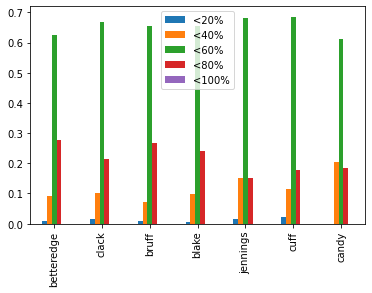

In [13]:
def constructBuckets(guiltyDict, key):
    scoresDict = {}
    scores = [pair[1] for pair in guiltyDict[key]]
    scoresDict[key] = scores
    df = pd.DataFrame(data=scoresDict)
    bins = np.array([0.0,0.2,0.4,0.6,0.8,1.0])
    return pd.cut(df[key], bins, labels=["<20%", "<40%", "<60%", "<80%", "<100%"]).value_counts(sort=False, normalize=True)

bucketDF = [pd.DataFrame(data=constructBuckets(guiltyDict, key)).transpose() for key in keys]
bucketDF = pd.concat(bucketDF)
bucketDF.plot.bar()
bucketDF

In [14]:
def getAverageGuilt(guiltyDict):
    guiltMeans = {}
    for key in keys:
        scores = [pair[1] for pair in guiltyDict[key]]
        guiltMeans[key] = statistics.mean(scores)
    return pd.DataFrame(data=guiltMeans, index=["Guilty Score"])

avgGuiltDF = getAverageGuilt(guiltyDict)
avgGuiltDF

,betteredge,clack,bruff,blake,jennings,cuff,candy
Guilty Score,0.525948,0.506312,0.52705,0.516672,0.491819,0.50554,0.488268


The diagram above demonstrates how each of the characters may be associated with guilt, on average, supplementing the distribution shown earlier.

### Guilt Topics with LDA

We can cross reference our sentence similarity score-based approach to approximate guilt by using latent Dirichlet allocation (LDA).
Instead of using the entire novel, we can use the sentences we obtained earlier, and filter them for a 'guilty' threshold of >= 0.6.
This reduces the previous 7000+ lines to 1672, across the different narrators.


We see that LDA yields topics such as

> Crime, Committed, Murder, Persons

and

> Time, Mind, Know, Felt

and 

> Time, Diamond, Mind, Think

which is consistent with our expectations. In The Moonstone, guilt is mainly associated with the potential to commit a crime (involving the loss of a diamond), and 
even related to the death of Rosanna Spearman and Lady Verinder. It is sufficient to say that the topics extracted with a guilty score of >=0 are that
of guiltiness.

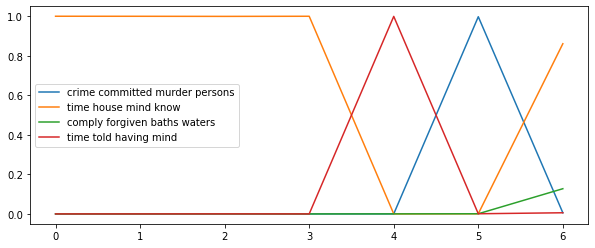

In [78]:
def getFilteredSents(guiltDF, minScore, narrator):
    filteredDF = guiltDF.loc[(guiltDF['guilt'] >= minScore) & (guiltDF['narrator'] == narrator)]
    return ' '.join(filteredDF.sentence.tolist())
textList = [getFilteredSents(guiltDF, 0.6, key) for key in keys]

def isRelevant(word):
    irrelevantWords = ['said', 'mr', 'ablewhite', 'rachel', 'godfrey', 'betteredge', 'clack', 
                       'bruff', 'blake', 'jennings', 'blake2', 'cuff', 'candy', 'gabriel', 'verinder',
                       'franklin', 'miss', 'lady', 'man', 'sergeant', 'rosanna', 'aunt', 'men', 'say',
                       'way',
                      ]
    return word not in irrelevantWords

moonstoneLabels = keys
countVectorizer = CountVectorizer(stop_words='english')
moonstoneCounts = countVectorizer.fit_transform(textList)
wordLabels = countVectorizer.get_feature_names() 
wordLabels = [word for word in set(wordLabels) if isRelevant(word)]
countVectorizer = CountVectorizer(stop_words='english', min_df=1, max_df=0.9, vocabulary=wordLabels) 
moonstoneCounts = countVectorizer.fit_transform(textList)

moonstoneDF = pd.DataFrame(moonstoneCounts.todense(), index=moonstoneLabels, columns=wordLabels)
numTopics = 4
lda = LatentDirichletAllocation(n_components=numTopics)
ldaOut = lda.fit_transform(moonstoneCounts)
lda.components_.shape
topics = ['Topic ' + str(x) for x in range(numTopics)]
topicWordMatrix = pd.DataFrame(lda.components_, index=topics, columns=wordLabels) 


labels = list(map(lambda x : ' '.join(list(topicWordMatrix.loc[x].sort_values(ascending=False).head(numTopics).index)), topics))
pd.DataFrame(ldaOut, columns=labels).plot(figsize=(10,4)) 

In [15]:
def getFilteredSentsCount(guiltDF, minScore):
    filteredDF = guiltDF.loc[(guiltDF['guilt'] >= minScore)]
    return len(filteredDF.index)

getFilteredSentsCount(guiltDF, 0.6)

1672

# Next Steps

We have a potential framework set up to derive insight into a character's emotions. However, we are far from finished and there are several improvements we can make.

One direction is to improve the classification of a monologue sentence, because it's currently inaccurate and diluting associated scores for the narrators. Otherwise, we could potentially drop the notion of filtering on monologues altogether, and look at the complete text -- in order to solve for general association.

Furthermore, we could look into different key-words or sentences pertaining Guilt, to see if we can extract more meaningful analysis. An idea would be to just simply look at "guilt".

Another direction could be to try different embeddings, either pre-trained or trained on a more relevant corpus. This would be time and computationally expensive but may provide interesting results.

# Conclusion

We explored the prevalence of Guilt in *The Moonstone*. By using some computational techniques, namely via Sentence Comparison and LDA, we can detect feelings of guilt for each of the narrators in the text.
We established a rudimentary framework for extracting emotion from a character, to help analyze the behavior and actions of each of the characters in a novel.

# Works Cited

<b id="f1">1</b> Collins, Wilkie. The Moonstone. Steve Farmer, ed. New York: Broadview Press Ltd., 1999. [↩](#a1)

<b id="f2">2</b> Cosine Similarity https://en.wikipedia.org/wiki/Cosine_similarity [↩](#a2)

<b id="f3">3</b> M. Honnibal, I. Montani, et al. Explosion AI. spaCy (2015). [Online]. Available:  https://spacy.io/usage/vectors-similarity
 [↩](#a3)

<b id="f4">4</b> Radim Řehůřek. RARE Technologies Ltd. (2009) Gensim. Available: https://radimrehurek.com/gensim/ [↩](#a4)

<b id="f5">5</b> Tomas Mikolov. Google. (2013) Word2Vec. Available: https://code.google.com/archive/p/word2vec/ [↩](#a5)
